In [1]:
# 1. Install and import required libraries
!pip install GEOparse --quiet

In [2]:
import GEOparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import ttest_ind

In [6]:
# 2. Load GSE33000 Dataset
gse = GEOparse.get_GEO("GSE33000", destdir=".")
metadata = gse.phenotype_data
expression_df = gse.pivot_samples("VALUE")

14-May-2025 03:15:38 DEBUG utils - Directory . already exists. Skipping.
DEBUG:GEOparse:Directory . already exists. Skipping.
14-May-2025 03:15:38 INFO GEOparse - File already exist: using local version.
INFO:GEOparse:File already exist: using local version.
14-May-2025 03:15:38 INFO GEOparse - Parsing ./GSE33000_family.soft.gz: 
INFO:GEOparse:Parsing ./GSE33000_family.soft.gz: 
14-May-2025 03:15:38 DEBUG GEOparse - DATABASE: GeoMiame
DEBUG:GEOparse:DATABASE: GeoMiame
14-May-2025 03:15:38 DEBUG GEOparse - SERIES: GSE33000
DEBUG:GEOparse:SERIES: GSE33000
14-May-2025 03:15:38 DEBUG GEOparse - PLATFORM: GPL4372
DEBUG:GEOparse:PLATFORM: GPL4372
14-May-2025 03:15:38 DEBUG GEOparse - SAMPLE: GSM1423780
DEBUG:GEOparse:SAMPLE: GSM1423780
14-May-2025 03:15:38 DEBUG GEOparse - SAMPLE: GSM1423781
DEBUG:GEOparse:SAMPLE: GSM1423781
14-May-2025 03:15:38 DEBUG GEOparse - SAMPLE: GSM1423782
DEBUG:GEOparse:SAMPLE: GSM1423782
14-May-2025 03:15:38 DEBUG GEOparse - SAMPLE: GSM1423783
DEBUG:GEOparse:SAMPLE

KeyError: 'characteristics_ch1'

In [15]:
# Step 3. Extract diagnosis labels
# The correct column based on your metadata is:
# 'characteristics_ch2.3.disease status'
labels = metadata["characteristics_ch2.3.disease status"].apply(
    lambda x: 'AD' if 'Alzheimer' in x else 'Control'
)
labels_binary = labels.apply(lambda x: 1 if x == 'AD' else 0)


In [17]:
# Step 4. Filter and normalize the gene expression data

# Match expression columns to metadata sample order
expression_df = expression_df[labels.index]

# Ensure numeric values
expression_df = expression_df.apply(pd.to_numeric, errors='coerce')

# Remove genes with any missing values
expression_df = expression_df.dropna()
expression_df = expression_df.loc[~expression_df.index.duplicated(keep='first')]

# Replace negative or infinite values (shouldn't be present, but to be safe)
expression_df = expression_df.clip(lower=0)

# Log2 transform and scale
data_log2 = np.log2(expression_df + 1)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_log2.T)  # Transpose: samples x genes


In [18]:
# Step 5. Differential Expression Analysis

# Separate samples by diagnosis label
ad_samples = data_scaled[labels_binary == 1]
ctrl_samples = data_scaled[labels_binary == 0]

# Perform two-sample t-test on each gene
t_stat, p_values = ttest_ind(ad_samples, ctrl_samples, axis=0)

# Collect top genes
results_df = pd.DataFrame({
    'Gene': expression_df.index,
    't_stat': t_stat,
    'p_value': p_values
})

# Sort by significance (smallest p-values first)
results_df = results_df.sort_values("p_value").reset_index(drop=True)

# Show top 10 genes
results_df.head(10)


,Gene,t_stat,p_value
0,10023804796,-18.460267,5.258040e-61
1,10025912352,-18.102879,3.732616e-59
2,10023814510,-17.814554,1.141394e-57
3,10023822861,-17.656497,7.387912e-57
4,10025906470,-17.598742,1.459860e-56
5,10023811346,-17.589104,1.635446e-56
6,10025907721,-17.258453,7.952242e-55
7,10023820589,-17.149941,2.829296e-54
8,10025908275,-16.815029,1.396540e-52
9,10023819040,-16.649625,9.480807e-52


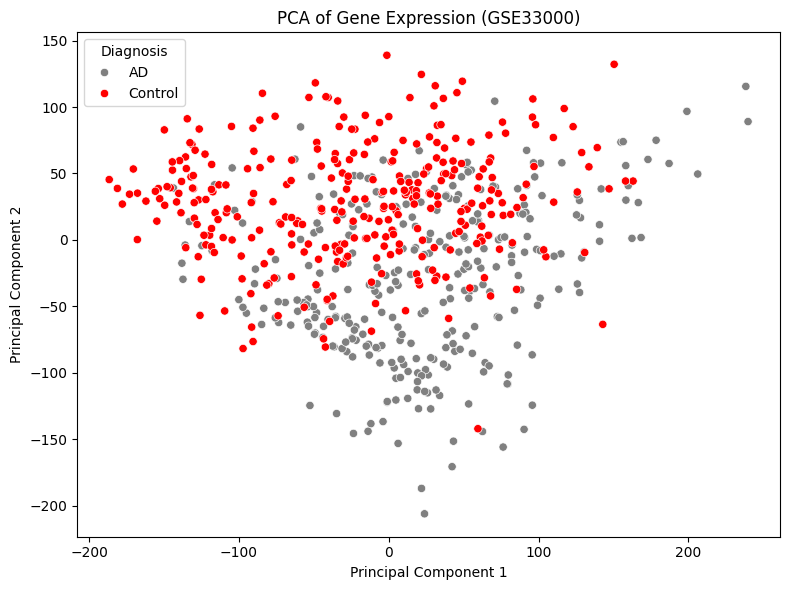

In [19]:
# Step 6. PCA Visualization

# Perform PCA on the scaled gene expression data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_scaled)

# Create a DataFrame for plotting
pca_df = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'Diagnosis': labels.values
})

# Plot PCA result
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Diagnosis", palette=["gray", "red"])
plt.title("PCA of Gene Expression (GSE33000)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Diagnosis")
plt.tight_layout()
plt.show()


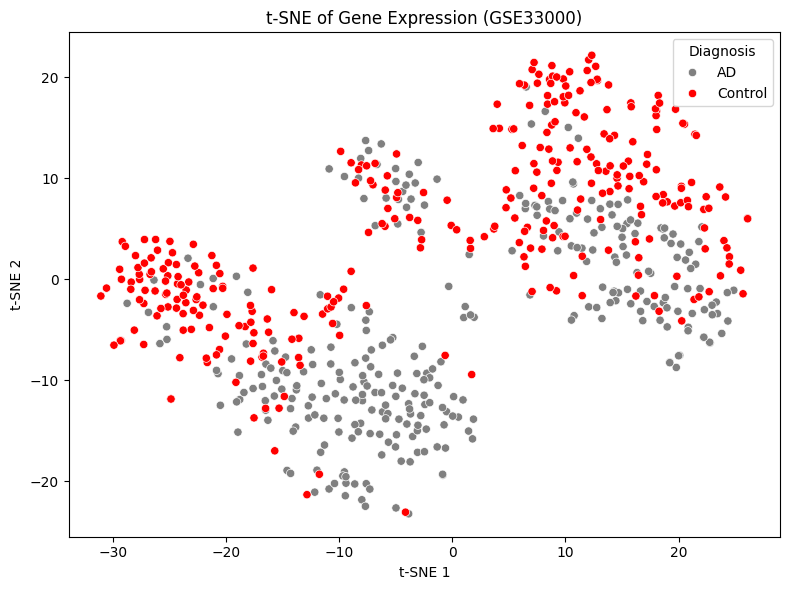

In [20]:
# Step 7. t-SNE Visualization

# Perform t-SNE on the scaled data
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(data_scaled)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame({
    'tSNE1': tsne_result[:, 0],
    'tSNE2': tsne_result[:, 1],
    'Diagnosis': labels.values
})

# Plot t-SNE result
plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_df, x='tSNE1', y='tSNE2', hue='Diagnosis', palette=["gray", "red"])
plt.title("t-SNE of Gene Expression (GSE33000)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Diagnosis")
plt.tight_layout()
plt.show()


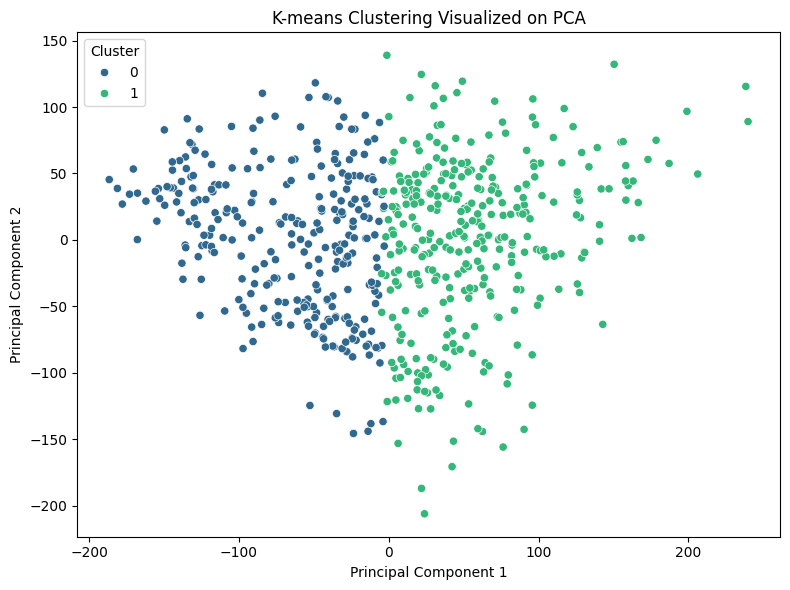

In [21]:
# Step 8. K-means Clustering

# Apply K-means clustering with 2 clusters (AD vs Control)
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled)

# Plot K-means result on PCA axes
pca_df['Cluster'] = kmeans_labels

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title("K-means Clustering Visualized on PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


🔍 Logistic Regression Classification Report:
              precision    recall  f1-score   support

     Control       0.98      0.89      0.93        55
          AD       0.92      0.99      0.95        70

    accuracy                           0.94       125
   macro avg       0.95      0.94      0.94       125
weighted avg       0.95      0.94      0.94       125



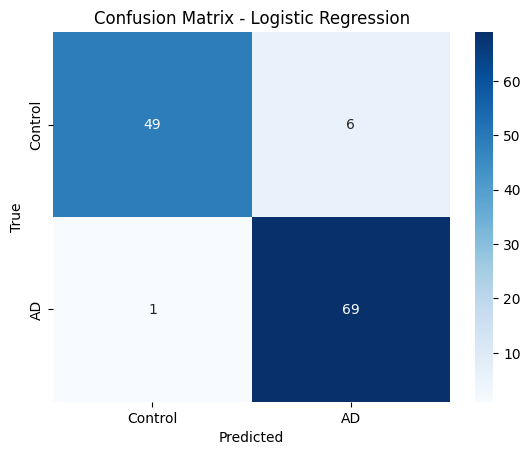

In [22]:
# Step 9. Classification - Logistic Regression

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data_scaled, labels_binary, test_size=0.2, random_state=42
)

# Initialize and train a logistic regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

# Make predictions
y_pred = logreg.predict(X_test)

# Evaluate the model
print("🔍 Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Control", "AD"]))

# Optional: Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Control", "AD"], yticklabels=["Control", "AD"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


🌲 Random Forest Classification Report:
              precision    recall  f1-score   support

     Control       0.86      0.89      0.88        55
          AD       0.91      0.89      0.90        70

    accuracy                           0.89       125
   macro avg       0.89      0.89      0.89       125
weighted avg       0.89      0.89      0.89       125



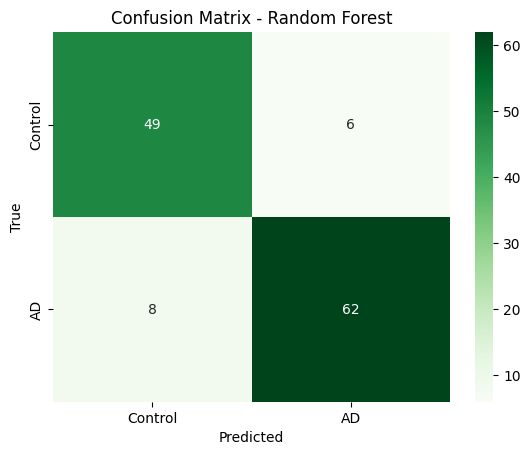

In [23]:
# Step 10. Classification - Random Forest

# Initialize and train the random forest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("🌲 Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["Control", "AD"]))

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', xticklabels=["Control", "AD"], yticklabels=["Control", "AD"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


<ipython-input-24-70ba3dbfa43c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


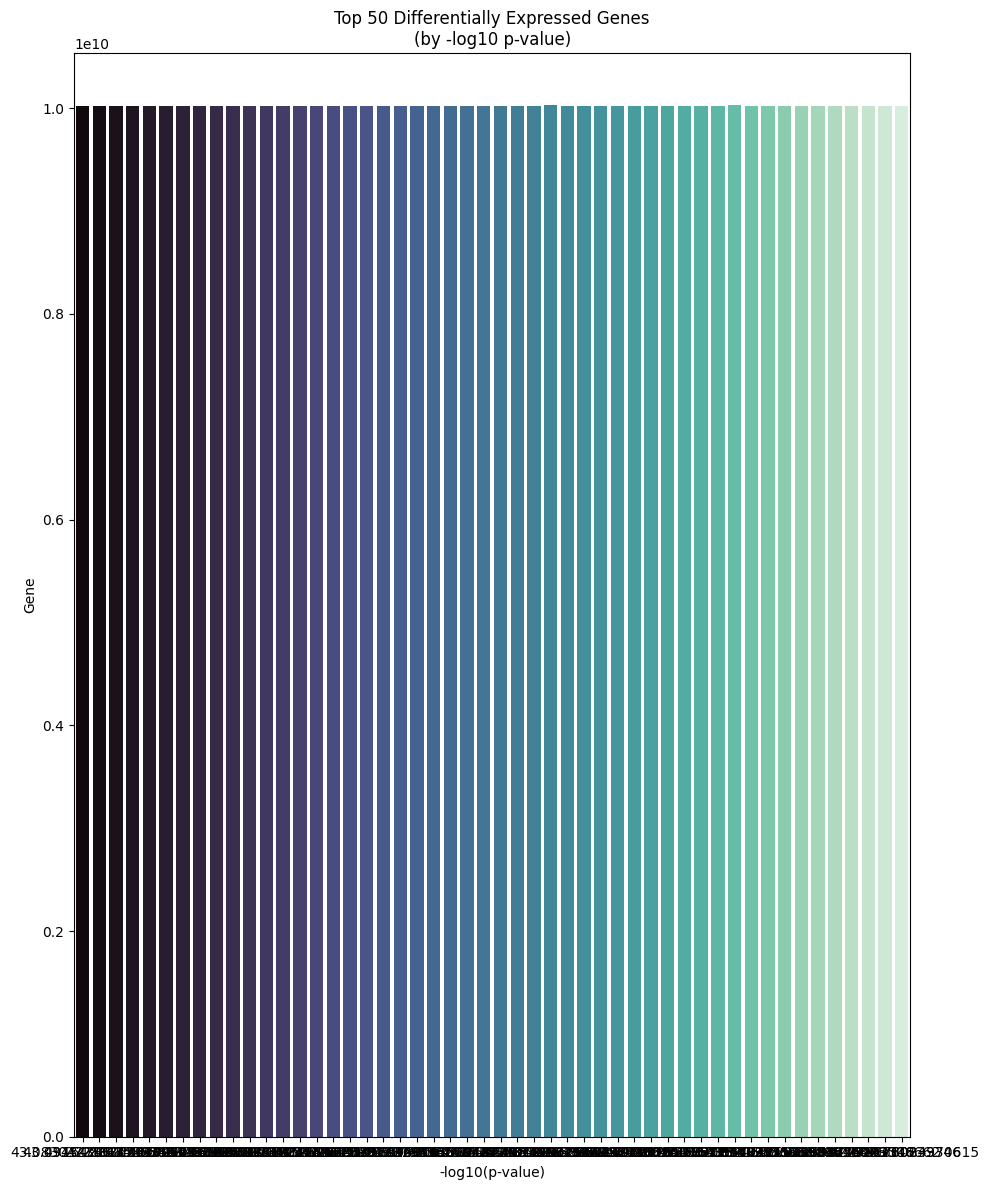

In [24]:
# Step 11. Summary of Top Marker Genes

# Display top 50 genes by significance
top_genes_df = results_df.head(50)

plt.figure(figsize=(10, 12))
sns.barplot(
    x=-np.log10(top_genes_df['p_value']),
    y=top_genes_df['Gene'],
    palette='mako'
)
plt.title('Top 50 Differentially Expressed Genes\n(by -log10 p-value)')
plt.xlabel('-log10(p-value)')
plt.ylabel('Gene')
plt.tight_layout()
plt.show()
